In [18]:
running_on_colab = False
# Import drive and connect
if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

#     import subprocess
#     subprocess.run("pip install pyrsgis", shell=True)
#     subprocess.run("pip install matplotlib_scalebar", shell=True)

    # Check GPU
    subprocess.run("nvidia-smi", shell=True)

In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

import dataUtils as diu
import plotEvalUtils as peu

import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num GPUs Available:  0
[]


In [20]:
# constants for program

input_bands = [i+1 for i in range(0,7)]
nBands = len(input_bands)
labels_band = 8

print('Analyzing bands: ', input_bands)
print('nBands: ', nBands)

downsampleMajority = False

diu.setGlobalVariables(input_bands, nBands)

if running_on_colab: image_base_path = "/content/drive/MyDrive/MangroveClassification/"
else: image_base_path = "./data/sentinal/"

loadModel = True

Analyzing bands:  [1, 2, 3, 4, 5, 6, 7]
nBands:  7


#### Getting training data

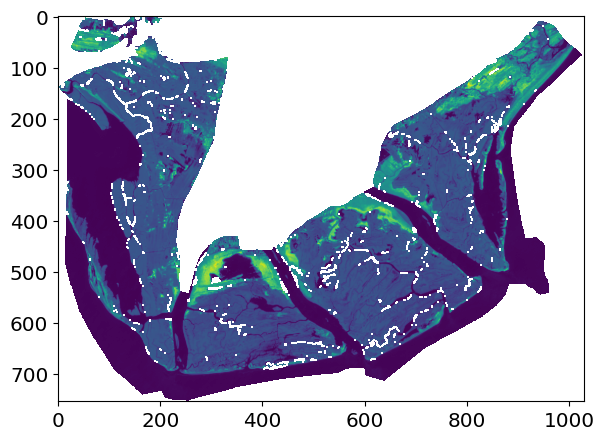

In [21]:
import rasterio
import matplotlib.pyplot as plt

# Specify the path to your GeoTIFF file
geotiff_path = './data/sentinal/krishna_3_2022.tif'

# Open the GeoTIFF file with rasterio
with rasterio.open(geotiff_path) as src:
    # Read the image data
    img = src.read(1)

plt.imshow(img)

In [22]:
# generate training data from chosen images
training_images = []

training_images.append(image_base_path + "krishna_3_2022.tif")

model_input_data, model_input_labels = diu.loadTrainingImages(training_images, downsampleMajority)
mask = model_input_labels != -1
model_input_labels = model_input_labels[mask]
model_input_data = model_input_data[mask] 
max_val = np.max(model_input_data)
model_input_data = model_input_data/max_val

(7, 754, 1030)
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
Using training data of length:  773056
class -1: 345585
class 0: 314166
class 1: 113305


#### Performing Hierarchical Clustering

In [28]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

def batch_hierarchical_clustering(X, n_clusters, batch_size):
    # Initialize an empty list to store cluster labels
    cluster_labels = []
    
    # Determine the number of batches
    num_batches = int(np.ceil(len(X) / batch_size))
    
    # Perform clustering for each batch
    for i in range(num_batches):
        # Define the start and end indices for the current batch
        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, len(X))
        
        # Extract the current batch from the data
        X_batch = X[start_index:end_index]
        
        # Perform hierarchical clustering on the current batch
        cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
        labels_batch = cluster.fit_predict(X_batch)
        
        # Compute cluster means of the current batch
        cluster_means = [np.mean(X_batch[labels_batch == j], axis=0) for j in range(n_clusters)]
        #print cluster means
        # print("Cluster means:", cluster_means)
        # Determine which cluster mean[0] is greater
        greater_mean_index = np.argmax([mean[6] for mean in cluster_means])

        if greater_mean_index == 1:
            labels_batch = 1 - labels_batch
        labels_batch = 1 - labels_batch

        cluster_labels.extend(labels_batch)
        
    return np.array(cluster_labels)

# Sample data
random_state = 42
# Parameters
n_clusters = 2
batch_size = 20000

# Perform batch hierarchical clustering
cluster_labels = batch_hierarchical_clustering(model_input_data, n_clusters, batch_size)

# Print cluster labels
print("Cluster labels:", cluster_labels)

Cluster labels: [1 1 1 ... 0 1 1]


#### Labels from Hierarchical Clustering

shape (773056,)

Predicted mangroves:


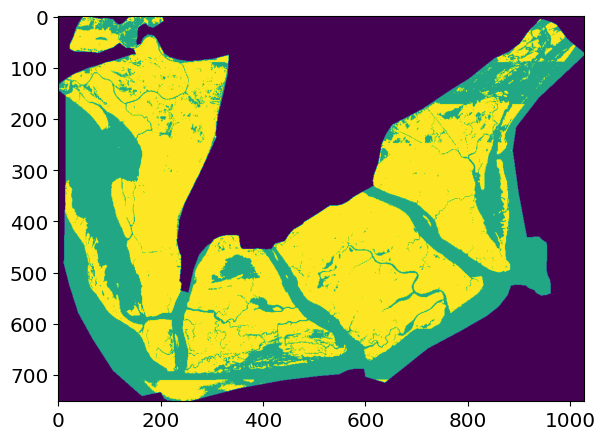

In [29]:
import matplotlib.pyplot as plt
count=0
mask=mask.ravel()
predict_new_final=[]
for i in range(len(mask)):
    if(mask[i]==False):
        predict_new_final.append(-1.5)
    else:
        predict_new_final.append(cluster_labels[count])
        count=count+1
print("shape",np.array(predict_new_final).shape)
prediction_new_image_2d=np.array(predict_new_final).reshape(752,1028)
# plot predicted mangroves
print('\nPredicted mangroves:')
plt.imshow(prediction_new_image_2d)

In [30]:
predict_new_final=np.array(predict_new_final)
predict_new_final=predict_new_final[mask]

In [31]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(model_input_data, predict_new_final, test_size=0.2, random_state=42, stratify=predict_new_final, shuffle=True)

# reshape it as an additional step for input into the NN
xTrain = xTrain.reshape((xTrain.shape[0], 1, nBands))
xTest = xTest.reshape((xTest.shape[0], 1, nBands))

print(xTrain.shape)
print(xTest.shape)

(341976, 1, 7)
(85495, 1, 7)


#### Training model using Multi Layer Perceptron by using the lables from Hierarchical Clustering

In [32]:
model = keras.Sequential([
      keras.layers.Flatten(input_shape=(1, nBands)),
      keras.layers.Dense(14, activation='relu'),
      keras.layers.Dense(14, activation='relu'),
      keras.layers.Dense(2, activation='softmax')])


# sample_weight = np.ones(shape=(len(yTrain),))
# sample_weight[yTrain == -1] = 0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((xTrain, yTrain))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(train_dataset, epochs=10)

print(model.summary())

Epoch 1/10
5344/5344 [==============================] - 4s 682us/step - loss: 0.2014 - accuracy: 0.9205
Epoch 2/10
5344/5344 [==============================] - 4s 690us/step - loss: 0.1839 - accuracy: 0.9264
Epoch 3/10
5344/5344 [==============================] - 4s 728us/step - loss: 0.1818 - accuracy: 0.9265
Epoch 4/10
5344/5344 [==============================] - 4s 684us/step - loss: 0.1809 - accuracy: 0.9267
Epoch 5/10
5344/5344 [==============================] - 4s 681us/step - loss: 0.1804 - accuracy: 0.9267
Epoch 6/10
5344/5344 [==============================] - 4s 671us/step - loss: 0.1801 - accuracy: 0.9267
Epoch 7/10
5344/5344 [==============================] - 4s 665us/step - loss: 0.1797 - accuracy: 0.9272
Epoch 8/10
5344/5344 [==============================] - 4s 674us/step - loss: 0.1789 - accuracy: 0.9267
Epoch 9/10
5344/5344 [==============================] - 4s 669us/step - loss: 0.1783 - accuracy: 0.9263
Epoch 10/10
5344/5344 [==============================] - 4s 691u

In [33]:
# Predict for test data
yTest_pred_prob = model.predict(xTest)
print(yTest_pred_prob.shape)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1
print(yTest_pred_prob)
peu.printClassificationMetrics(yTest, yTest_pred_prob)

2672/2672 [==============================] - 1s 465us/step
(85495, 2)
[0.00508569 0.9999999  0.9994816  ... 0.01452092 0.02421664 0.85591245]
Confusion matrix:
 [[29361  4742]
 [ 1848 49544]]

P-Score: 0.913, R-Score: 0.964
Accuracy: 0.923
f1: 0.938
              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90     34103
         1.0       0.91      0.96      0.94     51392

    accuracy                           0.92     85495
   macro avg       0.93      0.91      0.92     85495
weighted avg       0.92      0.92      0.92     85495



0.9376407577736142



Predicting for image: ./data/sentinal/krishna_3_2022.tif
(7, 754, 1030)
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
13359/13359 [==============================] - 7s 486us/step
image (427471,)
shape (773056,)
hi 752 1028

Predicted mangroves:
Saving image:  SavedPlots/BasicNN/krishna_3/PredictedMangroves_krishna_3_2022.png


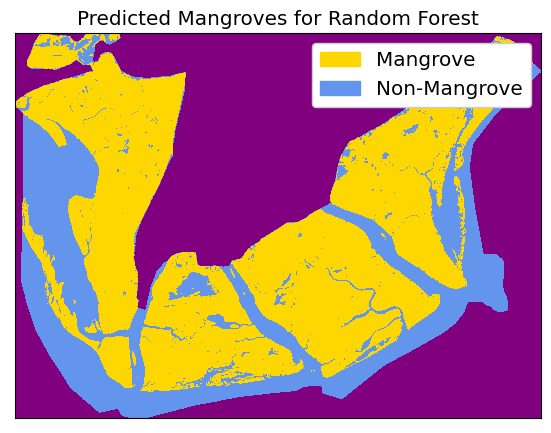

Saving image:  SavedPlots/BasicNN/krishna_3/GaL_krishna_3_2022.png


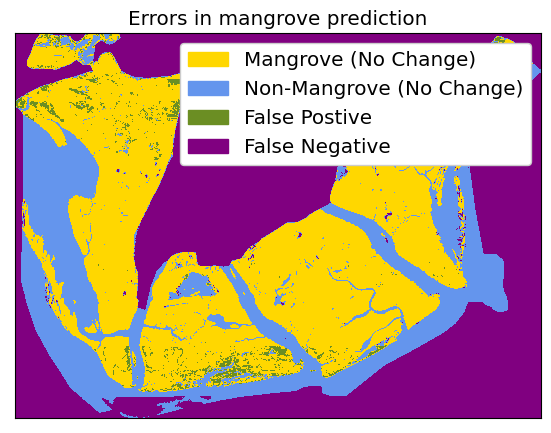

In [35]:
diu.predictOnImageUsingLabels(model, image_base_path + "krishna_3_2022.tif",cluster_labels)

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier

In [37]:
mlp_classifier = MLPClassifier(max_iter=1000, random_state=42)
gbc_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

#### Random Forest Classifier using the lables from Hierarchical Clustering

In [38]:
xTrain = xTrain.reshape((xTrain.shape[0], nBands))
xTest = xTest.reshape((xTest.shape[0], nBands))

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(xTrain, yTrain)

yPred = rf_classifier.predict(xTest)

accuracy = accuracy_score(yTest, yPred)
print(accuracy)

0.9374349377156559




Predicting for image: ./data/sentinal/krishna_3_2022.tif
(7, 754, 1030)
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
image (427471,)
shape (773056,)
hi 752 1028

Predicted mangroves:
Saving image:  SavedPlots/BasicNN/krishna_3/PredictedMangroves_krishna_3_2022.png


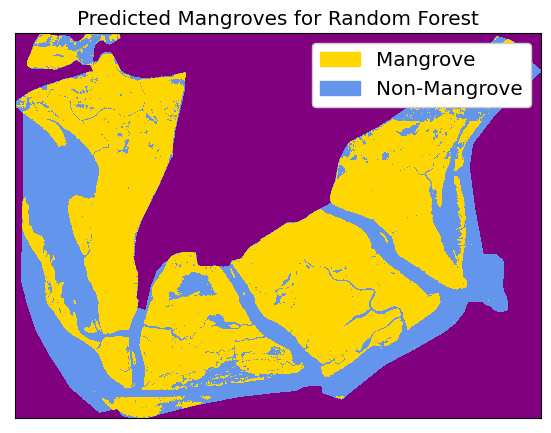

Saving image:  SavedPlots/BasicNN/krishna_3/GaL_krishna_3_2022.png


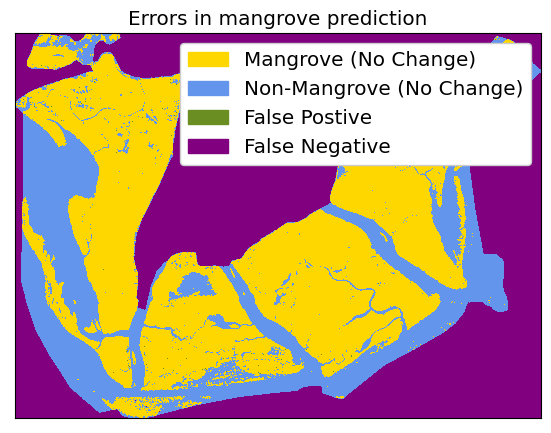

In [39]:
diu.predictOnImageRF(rf_classifier, image_base_path + "krishna_3_2022.tif",cluster_labels)

#### Gradrient Boosting Classifier using the lables from Hierarchical Clustering

In [40]:
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

gb_classifier.fit(xTrain, yTrain)
yPred = gb_classifier.predict(xTest)

accuracy = accuracy_score(yTest, yPred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(yTest, yPred))

Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.88      0.91     34103
         1.0       0.92      0.96      0.94     51392

    accuracy                           0.93     85495
   macro avg       0.93      0.92      0.92     85495
weighted avg       0.93      0.93      0.93     85495





Predicting for image: ./data/sentinal/krishna_3_2022.tif
(7, 754, 1030)
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
The "changeDimension()" function has moved to "array_to_table()" and will be deprecated in future versions. Please check the pyrsgis documentation at https://pyrsgis.readthedocs.io/en/master/ for more details.
image (427471,)
shape (773056,)
hi 752 1028

Predicted mangroves:
Saving image:  SavedPlots/BasicNN/krishna_3/PredictedMangroves_krishna_3_2022.png


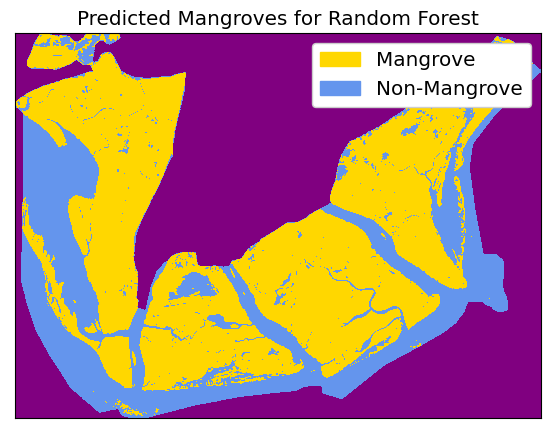

Saving image:  SavedPlots/BasicNN/krishna_3/GaL_krishna_3_2022.png


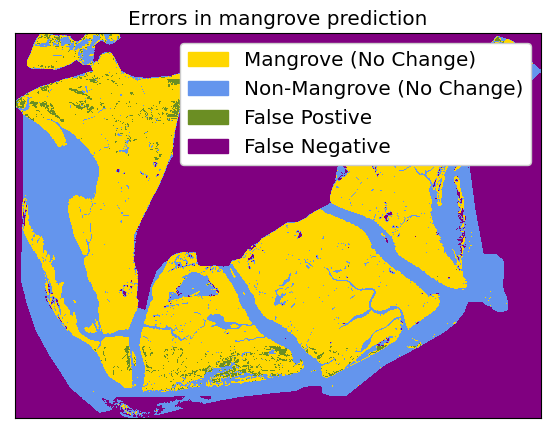

In [41]:
diu.predictOnImageRF(gb_classifier, image_base_path + "krishna_3_2022.tif",cluster_labels)